# 🌸 Flower Image Classification Tutorial

In this tutorial, we will implement a **Convolutional Neural Network (CNN)** for classifying flower images. We will:
- Preprocess and explore the dataset
- Build and train a CNN model
- Evaluate the model's performance

Let's get started!

## 📌 Step 1: Importing Necessary Libraries
Before we begin, let's import the necessary libraries for data handling, model training, and visualization.

In [1]:
import os
import random
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from itertools import repeat
import matplotlib.pyplot as plt
from six.moves import urllib
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization, Flatten, Conv2D, MaxPooling2D, Input
from keras.optimizers import SGD
%matplotlib inline

# Ensure TensorFlow is using GPU if available
# print('TensorFlow version:', tf.__version__)
# print('GPU Available:', tf.config.list_physical_devices('GPU'))

## 📂 Step 2: Downloading and Exploring the Dataset
We will now load our dataset and visualize some sample images to understand the data structure.

In [2]:
# Importing images from tensorflow compressed .tgz file...
FLOWERS_DIR = 'flower_photos' # Downloading to this directory drom the download URL.
def download_images():
  """If the images aren't already downloaded, save them to FLOWERS_DIR."""
  if not os.path.exists(FLOWERS_DIR):
    DOWNLOAD_URL = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
    print('Downloading flower images from %s...' % DOWNLOAD_URL)
    urllib.request.urlretrieve(DOWNLOAD_URL, 'flower_photos.tgz') # Like ```urlopen```.
    !tar xfz flower_photos.tgz
  print('Flower photos are located in %s' % FLOWERS_DIR)

# Download the images to flower_photos folder...
download_images()

Flower photos are located in flower_photos


In [3]:
# Extracting all filepaths iteratively...
base_path = 'flower_photos'
categories = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

# Load file paths to fnames list object...
fnames = []
for category in categories:
    flower_folder = os.path.join(base_path, category)
    file_names = os.listdir(flower_folder)
    full_path = [os.path.join(flower_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

print('number of images for each category:', [len(f) for f in fnames])

number of images for each category: [633, 898, 641, 699, 799]


In [4]:
print(fnames[0][0])
print(fnames[1][0])
print(fnames[2][0])
print(fnames[3][0])
print(fnames[4][0])

flower_photos/daisy/10770585085_4742b9dac3_n.jpg
flower_photos/dandelion/8842317179_d59cf218cb_n.jpg
flower_photos/roses/353897245_5453f35a8e.jpg
flower_photos/sunflowers/265450085_6e9f276e2e.jpg
flower_photos/tulips/495094547_fd2d999c44.jpg


## 🌿 Step 3: Image Preprocessing: Resizing, Normalization, and One-Hot Encoding

In [5]:
def preprocessor(data, shape=(192, 192)):
        """
        This function preprocesses reads in images, resizes them to a fixed shape and
        min/max transforms them before converting feature values to float32 numeric values
        required by onnx files.

        params:
            data
                list of unprocessed images

        returns:
            X
                numpy array of preprocessed image data

        """


        "Resize a color image and min/max transform the image"
        img = cv2.imread(data) # Read in image from filepath.
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # cv2 reads in images in order of blue green and red, we reverse the order for ML.
        img = cv2.resize(img, shape) # Change height and width of image.
        img = img / 255.0 # Min-max transform.


        # Resize all the images...
        X = np.array(img)
        X = np.expand_dims(X, axis=0) # Expand dims to add "1" to object shape [1, h, w, channels].
        X = np.array(X, dtype=np.float32) # Final shape for onnx runtime.
        return X

In [6]:
# Import image, load to array of shape height, width, channels, then min/max transform...

# Read in all images from filenames...
preprocessed_image_data = [preprocessor(x) for x in fnames[0] + fnames[1] + fnames[2] + fnames[3] + fnames[4]]

# Object needs to be an array rather than a list for Keras. (vstack converts above list to array object.)
X = np.vstack(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model.

In [7]:
print(len(preprocessed_image_data)) # Same number of elements as filenames.
print(preprocessed_image_data[0].shape) # Dimensions now 192, 192, 3 for all images.
print(preprocessed_image_data[0].min()) # Min value of every image is zero.
print(preprocessed_image_data[0].max()) # Max value of every image is one
X.shape

3670
(1, 192, 192, 3)
0.0
1.0


(3670, 192, 192, 3)

In [8]:
# Create y data made up of correctly ordered labels from file folders...
daisy = list(repeat("daisy", 633)) #i.e.: 633 filenames in daisy folder
dandelion = list(repeat("dandelion", 898))
roses = list(repeat("roses", 641))
sunflowers = list(repeat("sunflowers", 699))
tulips = list(repeat("tulips", 799))

# Combine into single list of y labels...
y_labels = daisy + dandelion + roses + sunflowers + tulips

# Check length, same as X above...
len(y_labels)

# Need to one-hot encode for Keras. Let's use Pandas...
y = pd.get_dummies(y_labels)
display(y)

,daisy,dandelion,roses,sunflowers,tulips
0,True,False,False,False,False
1,True,False,False,False,False
2,True,False,False,False,False
3,True,False,False,False,False
4,True,False,False,False,False
...,...,...,...,...,...
3665,False,False,False,False,True
3666,False,False,False,False,True
3667,False,False,False,False,True
3668,False,False,False,False,True


## 🖼️ Step 4: Visualizing Sample Images
Let's plot some images from our dataset to see the different categories of flowers.

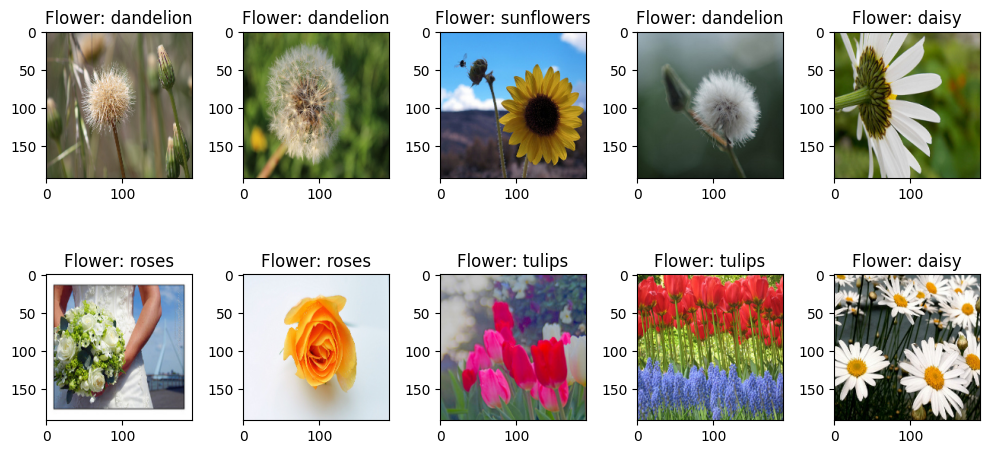

In [9]:
# Visualize images...
fig, ax = plt.subplots(2, 5)
fig.set_size_inches(10, 5)
for i in range(2):
    for j in range (5):
        l = np.random.randint(0, len(y_labels))
        ax[i, j].imshow(X[l])
        ax[i, j].set_title('Flower: ' + y_labels[l])

plt.tight_layout()
plt.show()

## 📊 Step 3: Splitting Dataset into Train and Test Sets

In [10]:
# train_test_split resized images...
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.20, random_state = 1987)

## 🏗️ Step 4: Building the CNN Model
We will now define a Convolutional Neural Network (CNN) model for image classification.

In [11]:
# Let's build a convnet model...
with tf.device('/device:GPU:0'): # "/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

        model = Sequential()
        model.add(Input(shape=(192, 192, 3))) # Define the input layer
        model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
        model.add(MaxPooling2D(pool_size=2))

        model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
        model.add(MaxPooling2D(pool_size=2))

        model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
        model.add(MaxPooling2D(pool_size=2))

        model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
        model.add(MaxPooling2D(pool_size=2))

        model.add(Flatten())
        model.add(Dense(128, activation='relu')) # One fully-connected layer of 100 neurons.
        model.add(Dense(64, activation='relu')) # One fully-connected layer of 100 neurons.
        model.add(Dense(5, activation='softmax')) # Last fully-connected layer of 5 outputs (5 categories).

        # Compile model...
        model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 192, 192, 32)        │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 96, 96, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 96, 96, 128)         │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 48, 48, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 48, 48, 128)         │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 64)          │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,179,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,303,781 (4.97 MB)

 Trainable params: 1,303,781 (4.97 MB)

 Non-trainable params: 0 (0.00 B)

## 🏋️ Step 5: Training the Model
We will train the CNN model on our dataset. Make sure your dataset is properly formatted before training.

In [12]:
# Fitting the NN to the Training set...
model.fit(X_train, y_train,epochs=10, verbose=1, validation_data=(X_test, y_test))

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 121ms/step - accuracy: 0.2926 - loss: 1.4861 - val_accuracy: 0.5422 - val_loss: 1.1334
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.5582 - loss: 1.0884 - val_accuracy: 0.4782 - val_loss: 1.2587
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.6107 - loss: 1.0043 - val_accuracy: 0.6594 - val_loss: 0.9120
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.6809 - loss: 0.8276 - val_accuracy: 0.5354 - val_loss: 1.3479
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.7014 - loss: 0.7774 - val_accuracy: 0.6349 - val_loss: 1.1104
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.7596 - loss: 0.6489 - val_accuracy: 0.6376 - val_loss: 0.9680
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.7943 - loss: 0.5232 - val_accuracy: 0.6798 - val_loss: 1.0039
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.8636 - loss: 0.3883 - val_accuracy: 0.6812 -

## 🔍 Step 9: Making Predictions
Once training is complete, we can make predictions on the test dataset.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 813ms/step


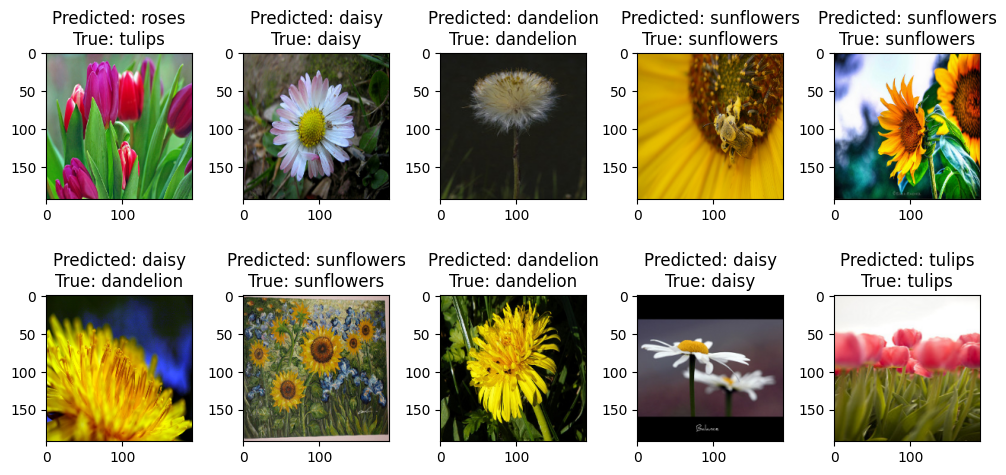

In [13]:
# Make predictions on few test samples
num_samples = 10
random_indices = random.sample(range(len(X_test)), num_samples)
random_images = X_test[random_indices]
random_labels = y_test.iloc[random_indices]  # Use iloc to index by row number
# Convert the true labels from one-hot encoded back to the flower names
true_labels = random_labels.idxmax(axis=1).values  # Get the column name (flower name) for the max value (one-hot encoded)

# Make predictions on the randomly selected images
predictions = model.predict(random_images)

# Get the predicted class for each sample
predicted_classes = np.argmax(predictions, axis=1)
predicted_labels = [y.columns[i] for i in predicted_classes]  # Use y columns for the predicted labels

# Plot the images with their predicted and actual labels
fig, ax = plt.subplots(2, 5)
fig.set_size_inches(10, 5)
for i in range(2):
    for j in range(5):
        idx = 5 * i + j
        ax[i, j].imshow(X_test[random_indices[idx]])
        ax[i, j].set_title(f'Predicted: {predicted_labels[idx]}\nTrue: {true_labels[idx]}')

plt.tight_layout()
plt.show()

## 📌 Conclusion
We have successfully built and trained a CNN model for flower image classification. You can experiment with different architectures and hyperparameters to improve performance.